In [7]:
import pandas as pd
import numpy as np

from itertools import product
import matplotlib.pyplot as plt
from networkx import draw_networkx, DiGraph

from causalnex.structure.notears import from_pandas
from pgmpy.models import BayesianNetwork
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import VariableElimination
from pgmpy.factors.discrete import DiscreteFactor
from pgmpy.inference import CausalInference

### Cargar los datos

In [12]:
df=pd.read_csv("/Dataset.csv")
#df.columns = ['BOT','C','N','V','S','L','Y']

display(df)

,BOT,C,N,V,S,L,Y
0,0,5,25,12,1,0,0
1,1,5,25,25,0,1,1
2,2,2,27,13,1,0,0
3,3,2,27,13,1,0,0
4,4,4,25,16,1,0,0
...,...,...,...,...,...,...,...
1195,1195,3,24,24,0,1,1
1196,1196,7,30,30,0,1,1
1197,1197,2,27,13,1,0,0
1198,1198,3,24,21,1,1,0


### Causal discovery (NOTEARS)

In [4]:
def plot_model(model, pos : dict = None, figsize : tuple = (10, 8), node_size : int = 5000):
    plt.figure(figsize=figsize) 
    plt.box(False)
    draw_networkx(DiGraph(model.edges), with_labels=True, pos=pos, node_color=['C{}'.format(i) for i in range(len(pos))], node_size=node_size, arrowsize=25)
    plt.show()
    


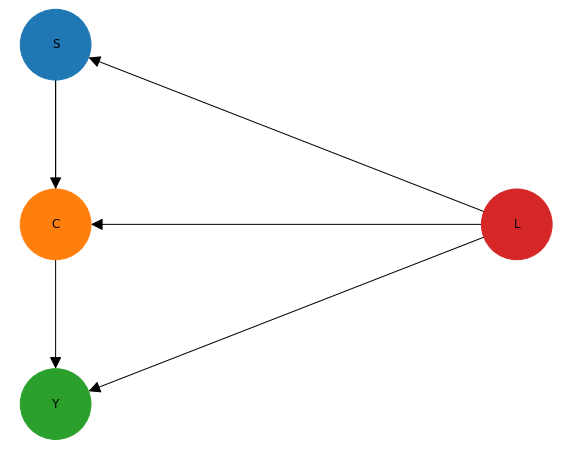

In [5]:
def discover_model():
    POS : dict = {'C': np.array([0, 0]), 'S': np.array([0, 1]),'L': np.array([1, 0]), 'Y': np.array([0, -1])}
    FIGSIZE : tuple = (10, 8)
    #Usar NOTEARS de causalnex para intentar inferir el DAG a partir de los datos
    data = df.drop(columns=["BOT","N","V"])
    notears_model = from_pandas(data, w_threshold=0.1,tabu_parent_nodes=["Y"])
    plot_model(model=notears_model, pos=POS, figsize=FIGSIZE)

discover_model()

### Crear el modelo

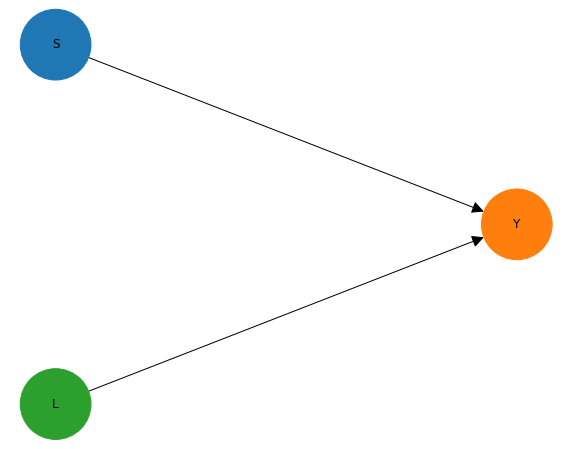

In [6]:
POS : dict = {'S': np.array([1,1]),'L': np.array([1, -1]),'Y': np.array([2, 0])}
FIGSIZE : tuple = (10, 8)
modelo = BayesianNetwork([('S', 'Y'), ('L', 'Y')])
plot_model(model=modelo, pos=POS, figsize=FIGSIZE)

### Tablas de probabilidad condicional (CPT)

In [7]:
def gen_CPT(d):
    modelo.fit(d)
    modelo.check_model()
    for cpd in modelo.get_cpds():
        print(cpd)

data = df.drop(columns=["BOT","C","N","V"])
gen_CPT(data)

+------+----------+
| S(0) | 0.259167 |
+------+----------+
| S(1) | 0.740833 |
+------+----------+
+------+------+---------------------+------+------+
| L    | L(0) | L(0)                | L(1) | L(1) |
+------+------+---------------------+------+------+
| S    | S(0) | S(1)                | S(0) | S(1) |
+------+------+---------------------+------+------+
| Y(0) | 0.5  | 0.8204667863554758  | 0.0  | 1.0  |
+------+------+---------------------+------+------+
| Y(1) | 0.5  | 0.17953321364452424 | 1.0  | 0.0  |
+------+------+---------------------+------+------+
+------+----------+
| L(0) | 0.464167 |
+------+----------+
| L(1) | 0.535833 |
+------+----------+


### Independencia de las variables

In [8]:
modelo.get_independencies()

(L ⟂ S)
(S ⟂ L)

### Consultas del tipo "What if" al modelo causal

In [9]:
## -> DisceteFactor es el metadato que especifica el tipo de objeto que retornará la función
def consultar_modelo(model : BayesianNetwork, variables : list, evidence : list = None, verbose : bool = True) -> DiscreteFactor:
    query = VariableElimination(model).query(variables, evidence, show_progress=False)
    if verbose:
        print(query)
    return query

## ¿Qué pasaría si el GBOT pudiera ver y escuchar?

In [10]:
q2 = consultar_modelo(modelo, variables=['Y'], evidence={'L':1,'S':1})
print(f"Tareas completadas si Guard_BOT ve y escucha (gira cuando se acercan por detrás): {int((q2.values[1] * data.shape[0]))}")

+------+----------+
| Y    |   phi(Y) |
+======+==========+
| Y(0) |   1.0000 |
+------+----------+
| Y(1) |   0.0000 |
+------+----------+
Tareas completadas si Guard_BOT ve y escucha (gira cuando se acercan por detrás): 0


## ¿Qué pasaría si el GBOT pudiera ver, pero no escuchar?


In [11]:
q2 = consultar_modelo(modelo, variables=['Y'], evidence={'L':0,'S':1})
print(f"Tareas completadas si Guard_BOT solo ve: {int((q2.values[1] * data.shape[0]))}")

+------+----------+
| Y    |   phi(Y) |
+======+==========+
| Y(0) |   0.8205 |
+------+----------+
| Y(1) |   0.1795 |
+------+----------+
Tareas completadas si Guard_BOT solo ve: 215


## ¿Qué pasaría si el GBOT no pudiera ver, pero sí escuchar?

In [12]:
q2 = consultar_modelo(modelo, variables=['Y'], evidence={'L':1,'S':0})
print(f"Tareas completadas si Guard_BOT solo escucha (gira pero no ve a quien se acerca por detrás -hay detección pero no identificación-): {int((q2.values[1] * data.shape[0]))}")

+------+----------+
| Y    |   phi(Y) |
+======+==========+
| Y(0) |   0.0000 |
+------+----------+
| Y(1) |   1.0000 |
+------+----------+
Tareas completadas si Guard_BOT solo escucha (gira pero no ve a quien se acerca por detrás -hay detección pero no identificación-): 1200


## Inferencia Causal

In [13]:
inferencia = CausalInference(model=modelo)
inferencia.estimate_ate("S", "Y", data=data, estimator_type="linear")


C:\Users\JVelez\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:130: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


-0.8875140607424002

In [14]:
inferencia.estimate_ate("L", "Y", data=data, estimator_type="linear")


0.3041370818453678

## Intervenciones

In [15]:
print(inferencia.query(variables=["Y"], do={"L": 0, "S":1}))

+------+----------+
| Y    |   phi(Y) |
+======+==========+
| Y(0) |   0.8205 |
+------+----------+
| Y(1) |   0.1795 |
+------+----------+


## Propensity score matching

In [16]:
from causalinference import CausalModel

## Aislar El efecto Resultado, el tratamiento Camino 1 y los demás serán confounders
Y = data.loc[:,"Y"].values
T = data.loc[:,"L"].values
confounders = data.drop(columns=["L","Y"]).values
model = CausalModel(Y,T,confounders)
model.est_via_ols(adj=0)
estimaciones = model.estimates
print(estimaciones)
print(model.summary_stats)
model.reset()


Treatment Effect Estimates: OLS

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE      0.304      0.026     11.903      0.000      0.254      0.354


Summary Statistics

                       Controls (N_c=557)         Treated (N_t=643)             
       Variable         Mean         S.d.         Mean         S.d.     Raw-diff
--------------------------------------------------------------------------------
              Y        0.180        0.384        0.484        0.500        0.304

                       Controls (N_c=557)         Treated (N_t=643)             
       Variable         Mean         S.d.         Mean         S.d.     Nor-diff
--------------------------------------------------------------------------------
             X0        1.000        0.000        0.516        0.500       -1.368



C:\Users\JVelez\Anaconda3\lib\site-packages\causalinference\estimators\ols.py:21: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  olscoef = np.linalg.lstsq(Z, Y)[0]


In [17]:
## Aislar El efecto Resultado, el tratamiento Camino 1 y los demás serán confounders
Y = data.loc[:,"Y"].values
T = data.loc[:,"S"].values
confounders = data.drop(columns=["S","Y"]).values
model = CausalModel(Y,T,confounders)
model.est_via_ols(adj=0)
estimaciones = model.estimates
print(estimaciones)
print(model.summary_stats)
model.reset()


Treatment Effect Estimates: OLS

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE     -0.888      0.011    -83.751      0.000     -0.908     -0.867


Summary Statistics

                       Controls (N_c=311)         Treated (N_t=889)             
       Variable         Mean         S.d.         Mean         S.d.     Raw-diff
--------------------------------------------------------------------------------
              Y        1.000        0.000        0.112        0.316       -0.888

                       Controls (N_c=311)         Treated (N_t=889)             
       Variable         Mean         S.d.         Mean         S.d.     Nor-diff
--------------------------------------------------------------------------------
             X0        1.000        0.000        0.373        0.484       -1.831



### Eleccion del camino
Mostrar descendentemente las probabilidades de éxito de cada camino

In [33]:
dftmp = pd.DataFrame(df2.groupby('C')['Y'].sum(),columns=['Y'])
display(dftmp)

,Y
C,
1,130
2,10
3,80
4,30
5,59
6,30
7,72


### Seleccionar el camino

In [42]:
print(dftmp.columns)
idx = df.Y.idxmax()
print(idx)

with open('c:/camino.txt', 'a') as fp:
    fp.write(str(idx))

Index(['Y'], dtype='object')
1


### Ejecutar el CausalBOT

In [ ]:
import subprocess

return_code = subprocess.call(["java", "-jar","C:/runcausalbot.jar"])
